In [1]:
import numpy as np
import pandas as pd
from scipy.signal import butter,filtfilt,find_peaks,find_peaks_cwt

from itertools import product
import glob # for reading files 
import neurokit2 as nk
import heartpy
from scipy import stats
import re # for reading files 

import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from plotly.subplots import make_subplots

import warnings

## Read files

In [112]:
bvp_file_list = glob.glob("wolf 1/*_bvp.csv")
eda_file_list = glob.glob("wolf 1/*_eda.csv")

In [113]:
bvp_file_list
# eda_file_list

['wolf 1/Recording_1_1653719783_e0-e2-e6-af-d4-98_ID15_bvp.csv',
 'wolf 1/Recording_1_1653719783_e0-e2-e6-af-d7-b0_ID16_bvp.csv',
 'wolf 1/Recording_1_1653719783_1c-9d-c2-84-71-48_ID4_bvp.csv',
 'wolf 1/Recording_1_1653719783_e0-e2-e6-af-db-0_ID14_bvp.csv',
 'wolf 1/Recording_1_1653719783_e0-e2-e6-af-d8-f4_ID6_bvp.csv',
 'wolf 1/Recording_1_1653719783_e0-e2-e6-af-d8-54_ID2_bvp.csv',
 'wolf 1/Recording_1_1653719783_e0-e2-e6-af-d9-4_ID17_bvp.csv',
 'wolf 1/Recording_1_1653719783_e0-e2-e6-af-db-b8_ID5_bvp.csv']

In [152]:
df_bvp = dict()
pattern = re.compile(r'(wolf 1/(?P<tester_num>.*)_(?P<macaddress>.*))_ID(?P<number>.*)_bvp.csv') # regular expression
for file in bvp_file_list:
    m = pattern.match(file)
    if m:
        df_bvp[m.group('number')] = pd.read_csv(file)

pattern = re.compile(r'(wolf 1/(?P<tester_num>.*)_(?P<macaddress>.*))_ID(?P<number>.*)_eda.csv')  # regular expression
df_eda = dict()
for file in eda_file_list:
    m = pattern.match(file)
    if m:
        df_eda[m.group('number')] = pd.read_csv(file)

In [153]:
sublist = df_bvp.keys()

In [154]:
# 18 no data --> remove

sublist = [ '4', '5', '6', '15', '16', '2', '17'] # '17', '19'
wolflist = ['4', '2']
goodlist = list(filter(lambda x: x not in wolflist, sublist))

In [155]:
goodlist

['5', '6', '15', '16', '17']

## Preprocessing

In [156]:
def set_timepass(data, time):
    data['timepass'] = data[time] - data[time].min()
    data['timepassSec'] = round(data['timepass']/1000, ndigits= 0)
    data['timepassMin'] = round(data['timepassSec']/60, ndigits= 0)
    return data

def lowpass(data, signaltype, freq, cutoff, order):
    w = cutoff /(freq/2)
    b,a = butter(order, w,'low')
    filtered_value =  filtfilt(b,a,data[signaltype])
    return filtered_value

In [157]:
for key in sublist:
    df_bvp[key] = set_timepass(df_bvp[key],'localTime')
    df_eda[key] = set_timepass(df_eda[key],'localTime')

In [158]:
df_bvp['16']

,localTime,remoteTime,label,bvp,signalOK,timepass,timepassSec,timepassMin
0,1653719779575,319284127,NaN,1666,0,0,0.0,0.0
1,1653719779575,319279127,NaN,1645,0,0,0.0,0.0
2,1653719779575,319274127,NaN,1622,0,0,0.0,0.0
3,1653719779575,319269127,NaN,1605,0,0,0.0,0.0
4,1653719779575,319264127,NaN,1590,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...
415695,1653721823358,-1898163139,day4,1539,0,2043783,2044.0,34.0
415696,1653721823358,-1898168139,day4,1539,0,2043783,2044.0,34.0
415697,1653721823358,-1898173139,day4,1539,0,2043783,2044.0,34.0
415698,1653721823358,-1898178139,day4,1541,0,2043783,2044.0,34.0


In [159]:
for key in sublist:
    df_bvp[key]['bvp_filtered'] = lowpass(df_bvp[key], 'bvp', 200, 4, 4)
    df_eda[key]['eda_filtered_good'] = lowpass(df_eda[key],'eda_filtered', 10, 0.5, 2) 

## Generate features

In [123]:
import heartpy as hp

In [124]:
def get_hrv_features(data, window, increment):
    hrv_list = []
    timepassSec= []
    
    i = data['timepassSec'].min()
    while True: 
        signalok = (data['timepassSec'] >= i)&(data['timepassSec'] < i + window)
        
        # count samples marked as signalOK  > referring to the sample rate (200HZ), the code will execute when the sample numbers >= 200
        if signalok.sum() >= 0:
            bvp_list = data['bvp_filtered'][signalok]
            info =  nk.ppg_findpeaks(hp.enhance_peaks(bvp_list),sampling_rate=200, method = 'elgendi') 
            peaks = info['PPG_Peaks']
            peaks = peaks[np.logical_not(np.isnan(peaks))]
            hrv = nk.hrv(peaks, sampling_rate =200, show = False)[['HRV_MeanNN', 'HRV_SDNN', 'HRV_pNN50','HRV_LFHF']]
            i = i + increment
            hrv_list.append(hrv)
            timepassSec.append(i+increment)
        else:
            i = i + increment          
        if i > data['timepassSec'].max() - window:
            break    
    return hrv_list,timepassSec

In [160]:
def get_eda_features(data):
    signals, info = nk.eda_process(data, sampling_rate= 10)
    value = signals[['EDA_Tonic', 'EDA_Phasic','SCR_Peaks']]
    # other features : 'SCR_Onsets','SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime','SCR_Recovery', 'SCR_RecoveryTime'
    return value

In [126]:
hrv = dict()
hrv_dataframe = dict()
timepassSec = dict()
session_label = dict()

for key in sublist:
    print(key)
    hrv[key] = get_hrv_features(df_bvp[key], 120, 60)[0]   # 240s/ window , sliding 120s each 
    timepassSec[key] = get_hrv_features(df_bvp[key], 120, 60)[1]

    concatelist =[]
    for i in range(len(hrv[key])):
        concatelist.append(hrv[key][i])
            
    hrv_dataframe[key] =pd.concat(concatelist, axis=0).reset_index()
    hrv_dataframe[key]['timepassSec'] = timepassSec[key]
    hrv_dataframe[key]['timepassMin'] = round(hrv_dataframe[key]['timepassSec']/60, ndigits= 0)
    hrv_dataframe[key]['subject_number'] = key

4
5


/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 77 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 77 (the max).
  warn(


6
15
16


/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 91 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 91 (the max).
  warn(


2


/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 152 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 150 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 152 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexi

17


/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 100 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 100 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexity_k.py:83: NeuroKitWarning: The optimal kmax value detected is 2 or less. There may be no plateau in this case. You can inspect the plot by set `show=True`. We will return optimal k_max = 100 (the max).
  warn(
/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/neurokit2/complexity/optim_complexi

In [127]:
hrv_dataframe['2']

,index,HRV_MeanNN,HRV_SDNN,HRV_pNN50,HRV_LFHF,timepassSec,timepassMin,subject_number
0,0,454.962406,99.493048,37.218045,0.739781,120.0,2.0,2
1,0,457.320755,86.334176,26.792453,0.506047,180.0,3.0,2
2,0,434.086022,42.958987,18.279570,0.710300,240.0,4.0,2
3,0,426.596491,75.690451,30.526316,0.793737,300.0,5.0,2
4,0,439.079422,62.205546,26.714801,0.773267,360.0,6.0,2
5,0,452.966418,50.019348,20.149254,0.293675,420.0,7.0,2
6,0,444.926740,54.819172,23.076923,0.906168,480.0,8.0,2
7,0,429.487633,47.862121,25.441696,0.822708,540.0,9.0,2
8,0,416.335616,65.675949,32.191781,0.546688,600.0,10.0,2
9,0,405.416667,62.821692,25.666667,0.897251,660.0,11.0,2


In [ ]:
# global
meanNN = dict() # for later normalization 
RR = dict() # overall RR intervals for each subject
for key in sublist:
    print(key)
    info = nk.ppg_findpeaks(hp.enhance_peaks(df_bvp[key]['bvp_filtered'].copy()), sampling_rate=200, method='elgendi')
    peaks = info['PPG_Peaks']
    peaks = peaks[np.logical_not(np.isnan(peaks))]
    meanNN[key] = nk.hrv(peaks, sampling_rate =200, show = False)[['HRV_MeanNN']]
    RR[key] = np.diff(peaks)/200 * 1000 
    df_bvp[key]['bvp_peaks'] = df_bvp[key].iloc[np.array(peaks)]['bvp_filtered']

In [129]:
hrv_features =['HRV_MeanNN', 'HRV_SDNN', 'HRV_pNN50','HRV_LFHF']

for key in sublist:
    for feature in hrv_features:
        # hrv_dataframe[key]['normalized_'+ feature]  = hrv_dataframe[key][feature].apply(lambda x: x/(meanNN[key]['HRV_MeanNN']))
        hrv_dataframe[key]['normalized_'+ feature]  = hrv_dataframe[key][feature].apply(lambda x: x/800)

In [138]:
hrv_dataframe['17']

,index,HRV_MeanNN,HRV_SDNN,HRV_pNN50,HRV_LFHF,timepassSec,timepassMin,subject_number,normalized_HRV_MeanNN,normalized_HRV_SDNN,normalized_HRV_pNN50,normalized_HRV_LFHF
0,0,681.235955,85.894367,37.640449,3.567291,120.0,2.0,17,0.851545,0.107368,0.047051,0.004459
1,0,655.513514,92.368479,44.864865,1.789845,180.0,3.0,17,0.819392,0.115461,0.056081,0.002237
2,0,663.763736,111.345285,52.197802,0.354367,240.0,4.0,17,0.829705,0.139182,0.065247,0.000443
3,0,712.147059,127.811375,53.529412,0.772068,300.0,5.0,17,0.890184,0.159764,0.066912,0.000965
4,0,726.656627,116.256494,46.987952,0.668595,360.0,6.0,17,0.908321,0.145321,0.058735,0.000836
5,0,676.005587,96.800472,52.513966,0.515247,420.0,7.0,17,0.845007,0.121001,0.065642,0.000644
6,0,658.288043,93.999934,51.086957,0.505773,480.0,8.0,17,0.822860,0.117500,0.063859,0.000632
7,0,653.486486,103.282438,48.108108,0.984991,540.0,9.0,17,0.816858,0.129103,0.060135,0.001231
8,0,605.251256,111.022280,53.768844,0.693076,600.0,10.0,17,0.756564,0.138778,0.067211,0.000866
9,0,590.315534,88.801079,55.825243,0.815378,660.0,11.0,17,0.737894,0.111001,0.069782,0.001019


## Plot

In [139]:
# concat to one file
concatelist = []
for key in wolflist:
    concatelist.append(hrv_dataframe[key])
    
hrv_wolf_all = pd.concat(concatelist, axis = 0).reset_index()

In [140]:
hrv_wolf_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   level_0                66 non-null     int64  
 1   index                  66 non-null     int64  
 2   HRV_MeanNN             66 non-null     float64
 3   HRV_SDNN               66 non-null     float64
 4   HRV_pNN50              66 non-null     float64
 5   HRV_LFHF               66 non-null     float64
 6   timepassSec            66 non-null     float64
 7   timepassMin            66 non-null     float64
 8   subject_number         66 non-null     object 
 9   normalized_HRV_MeanNN  66 non-null     float64
 10  normalized_HRV_SDNN    66 non-null     float64
 11  normalized_HRV_pNN50   66 non-null     float64
 12  normalized_HRV_LFHF    66 non-null     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 6.8+ KB


/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/var/folders/6m/x032bzms74b2t_sjzllbwgwc0000gn/T/ipykernel_72453/1633487994.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(time, plot2['mean'],'-',color = 'orange',linewidth = 2,linestyle='dashed')


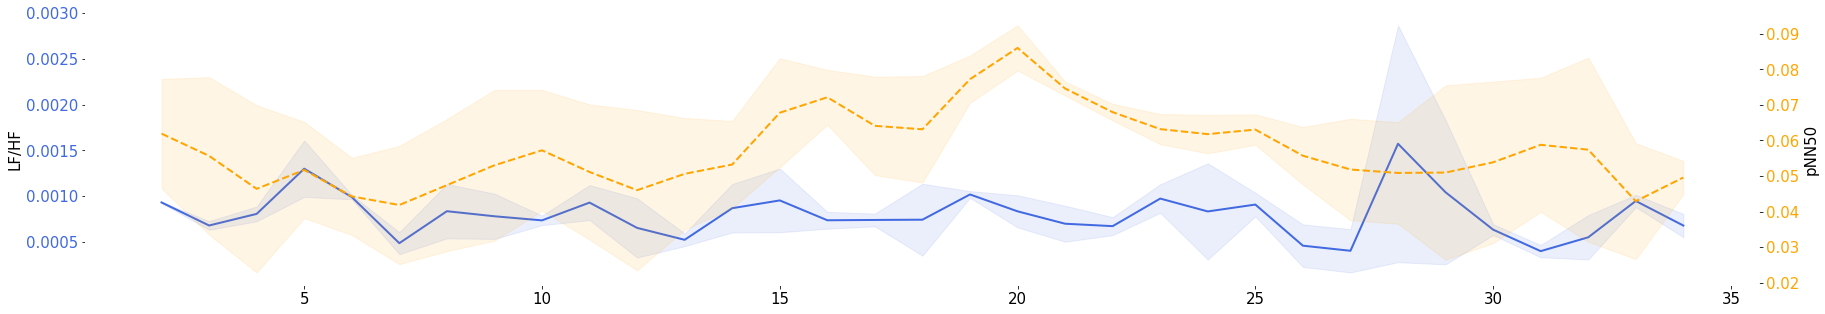

In [142]:
plot = hrv_wolf_all[hrv_wolf_all['timepassMin'] <= 43].groupby(['timepassMin']).agg([np.mean, stats.sem, np.std])
plot1 = plot['normalized_HRV_LFHF']
plot2 = plot['normalized_HRV_pNN50']

time = plot1.index
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(time, plot1['mean'],'-',color = 'royalblue',linewidth = 2)
ax1.fill_between(time, plot1['mean'] - plot1['sem'], plot1['mean']+plot1['sem'],alpha = 0.1, color = 'royalblue')

ax1.set_ylabel('LF/HF',color = 'black',fontsize = 15)
ax1.tick_params(axis = 'y',labelcolor = 'royalblue',labelsize = 15)
ax1.tick_params(axis = 'x',labelcolor = 'black',labelsize =15)

#ax2 = ax1
ax2 = ax1.twinx()
ax2.plot(time, plot2['mean'],'-',color = 'orange',linewidth = 2,linestyle='dashed')
ax2.fill_between(time, plot2['mean'] - plot2['sem'], plot2['mean']+ plot2['sem'],alpha = 0.1, color = 'orange')

ax2.set_ylabel('pNN50',color = 'black',fontsize = 15)
ax2.tick_params(axis = 'y',labelcolor = 'orange',labelsize = 15)
ax2.tick_params(axis = 'x',labelcolor = 'black',labelsize =15)

plt.savefig('/Users/zhuoqi/Desktop/game1_hrv_wolf.png', format = 'png')



/Users/zhuoqi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/groupby/generic.py:303: FutureWarning: Dropping invalid columns in SeriesGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the aggregating function.
  results[key] = self.aggregate(func)
/var/folders/6m/x032bzms74b2t_sjzllbwgwc0000gn/T/ipykernel_72453/1607531251.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(time, plot2['mean'],'-',color = 'orange',linewidth = 2,linestyle='dashed')


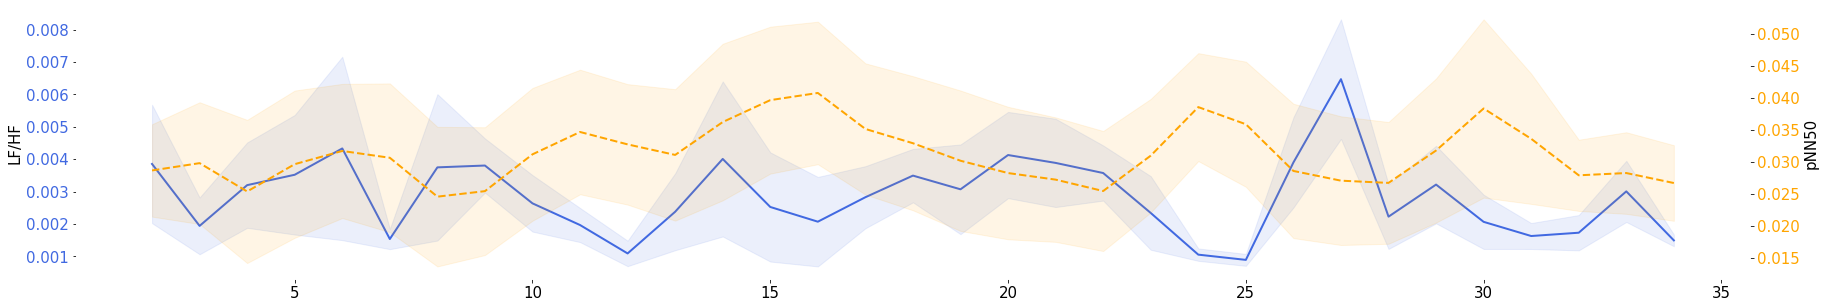

In [143]:
# concat to one file
concatelist = []
for key in goodlist:
    concatelist.append(hrv_dataframe[key])
    
hrv_good_all = pd.concat(concatelist, axis = 0).reset_index()

plot = hrv_good_all[hrv_good_all['timepassMin'] <= 43].groupby(['timepassMin']).agg([np.mean, stats.sem,np.std])
plot1 = plot['normalized_HRV_LFHF']
plot2 = plot['normalized_HRV_pNN50']

time = plot1.index
fig, ax1 = plt.subplots(figsize=(30,5))
ax1.plot(time, plot1['mean'],'-',color = 'royalblue',linewidth = 2)
ax1.fill_between(time, plot1['mean'] - plot1['sem'], plot1['mean']+plot1['sem'],alpha = 0.1, color = 'royalblue')

ax1.set_ylabel('LF/HF',color = 'black',fontsize = 15)
ax1.tick_params(axis = 'y',labelcolor = 'royalblue',labelsize = 15)
ax1.tick_params(axis = 'x',labelcolor = 'black',labelsize =15)

#ax2 = ax1
ax2 = ax1.twinx()
ax2.plot(time, plot2['mean'],'-',color = 'orange',linewidth = 2,linestyle='dashed')
ax2.fill_between(time, plot2['mean'] - plot2['sem'], plot2['mean']+ plot2['sem'],alpha = 0.1, color = 'orange')

ax2.set_ylabel('pNN50',color = 'black',fontsize = 15)
ax2.tick_params(axis = 'y',labelcolor = 'orange',labelsize = 15)
ax2.tick_params(axis = 'x',labelcolor = 'black',labelsize =15)

plt.savefig('/Users/zhuoqi/Desktop/game1_hrv_good.png', format = 'png')



In [197]:
eda_dataframe['2']['label'].fillna('night1')

0        night1
1        night1
2        night1
3        night1
4        night1
          ...  
21300      day4
21301      day4
21302      day4
21303      day4
21304      day4
Name: label, Length: 21305, dtype: object

In [ ]:
eda_dataframe['2'][['label', 'timepassMin']].groupby(['timepassMin']).agg(lambda x: x.value_counts()[0]).reset_index()

In [161]:
def get_eda_features(data):
    signals, info = nk.eda_process(data, sampling_rate= 10)
    value = signals[['EDA_Tonic', 'EDA_Phasic','SCR_Peaks']]
    # other features : 'SCR_Onsets','SCR_Peaks', 'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime','SCR_Recovery', 'SCR_RecoveryTime'
    return value

In [162]:
eda_dataframe = dict()
for key in sublist:
    value = get_eda_features(df_eda[key]['eda_filtered_good'])
    eda_dataframe[key] = pd.concat([df_eda[key].reset_index(),value], axis=1)
    eda_dataframe[key]['eda_diff']= eda_dataframe[key]['eda_filtered_good'].diff()
    eda_dataframe['subject_number'] = key
    eda_dataframe['label'] = df_eda[key]['label']
#     eda_dataframe[key]['label'] = eda_dataframe[key]['label'].fillna('no mark')


# concat to one file
concatelist2 = []
for key in wolflist:
    concatelist2.append(eda_dataframe[key])
    
eda_wolf_all = pd.concat(concatelist2, axis = 0).reset_index()

# concat to one file
concatelist3 = []
for key in goodlist:
    concatelist3.append(eda_dataframe[key])
    
eda_good_all = pd.concat(concatelist3, axis = 0).reset_index()

In [163]:
dfminmax = pd.DataFrame()

for i in wolflist:
    df = pd.DataFrame()
    df['X'] = df_eda[i]['timepassMin']
    df['Y'] = df_eda[i]['eda_filtered_good']
    df['Y2'] = df_eda[i]['eda']
    df['subject_number'] = i
    
        
    # 10 Hz
    n= round(10*60*0.5) # number of points to be checked before and after 
    # Find local peaks
    
    df['max'] = df.iloc[ find_peaks(df['Y'], prominence=50, distance=n)[0]]['Y']
    df['min'] = df.iloc[ find_peaks(df['Y']*-1 + 4095*2, prominence=50, distance=n)[0]]['Y']
    dfminmax = dfminmax.append(df, ignore_index=True)
    
dfmin = pd.DataFrame()
dfmax = pd.DataFrame()
dfmin = dfmin.append(dfminmax, ignore_index = True)
dfmax = dfmax.append(dfminmax, ignore_index = True)


binSizeMinutes = 1

dfmin.dropna( subset=['min'], inplace=True)
dfmax.dropna( subset=['max'], inplace=True)
dfmin['X-bins'] = dfmin['X'] // binSizeMinutes
dfmax['X-bins'] = dfmax['X'] // binSizeMinutes


binsMin = pd.DataFrame(columns=['time','sizeMin','number','extrema'])
binsMax = pd.DataFrame(columns=['time','sizeMin','number','extrema'])

earliestbin = dfmin['X-bins'].min()
dfmin['X-binsZeroed'] = dfmin['X-bins'] - earliestbin
latestbin = dfmin['X-binsZeroed'].max()

for i in range(0, int(latestbin+1)):
    numberOfExtremaInBin = dfmin['X-binsZeroed'][(dfmin['X-binsZeroed'] == i)].count()
    #print (i, numberOfExtremaInBin)
    binsMin = binsMin.append({'time':int(earliestbin*binSizeMinutes + binSizeMinutes*i), 'sizeMin':binSizeMinutes, 'number':i, 'extrema':numberOfExtremaInBin}, ignore_index=True)

    
earliestbin = dfmax['X-bins'].min()
dfmax['X-binsZeroed'] = dfmax['X-bins'] - earliestbin
latestbin = dfmax['X-binsZeroed'].max()

for i in range(0, int(latestbin+1)):
    numberOfExtremaInBin = dfmax['X-binsZeroed'][(dfmax['X-binsZeroed'] == i)].count()
    #print (i, numberOfExtremaInBin)
    binsMax = binsMax.append({'time':earliestbin*binSizeMinutes + binSizeMinutes*i, 'sizeMin':binSizeMinutes, 'number':i, 'extrema':numberOfExtremaInBin}, ignore_index=True)

    
    
binsMin['number'] = binsMin['number'].astype(int)
binsMax['number'] = binsMax['number'].astype(int)

wolf_extrema = binsMin

In [164]:
dfminmax = pd.DataFrame()

for i in goodlist:
    df = pd.DataFrame()
    df['X'] = df_eda[i]['timepassMin']
    df['Y'] = df_eda[i]['eda_filtered_good']
    df['Y2'] = df_eda[i]['eda']
    df['subject_number'] = i
    
        
    # 10 Hz
    n= round(10*60*0.5) # number of points to be checked before and after 
    # Find local peaks
    
    df['max'] = df.iloc[ find_peaks(df['Y'], prominence=50, distance=n)[0]]['Y']
    df['min'] = df.iloc[ find_peaks(df['Y']*-1 + 4095*2, prominence=50, distance=n)[0]]['Y']
    dfminmax = dfminmax.append(df, ignore_index=True)
    
dfmin = pd.DataFrame()
dfmax = pd.DataFrame()
dfmin = dfmin.append(dfminmax, ignore_index = True)
dfmax = dfmax.append(dfminmax, ignore_index = True)


binSizeMinutes = 1

dfmin.dropna( subset=['min'], inplace=True)
dfmax.dropna( subset=['max'], inplace=True)
dfmin['X-bins'] = dfmin['X'] // binSizeMinutes
dfmax['X-bins'] = dfmax['X'] // binSizeMinutes


binsMin = pd.DataFrame(columns=['time','sizeMin','number','extrema'])
binsMax = pd.DataFrame(columns=['time','sizeMin','number','extrema'])

earliestbin = dfmin['X-bins'].min()
dfmin['X-binsZeroed'] = dfmin['X-bins'] - earliestbin
latestbin = dfmin['X-binsZeroed'].max()

for i in range(0, int(latestbin+1)):
    numberOfExtremaInBin = dfmin['X-binsZeroed'][(dfmin['X-binsZeroed'] == i)].count()
    #print (i, numberOfExtremaInBin)
    binsMin = binsMin.append({'time':int(earliestbin*binSizeMinutes + binSizeMinutes*i), 'sizeMin':binSizeMinutes, 'number':i, 'extrema':numberOfExtremaInBin}, ignore_index=True)

    
earliestbin = dfmax['X-bins'].min()
dfmax['X-binsZeroed'] = dfmax['X-bins'] - earliestbin
latestbin = dfmax['X-binsZeroed'].max()

for i in range(0, int(latestbin+1)):
    numberOfExtremaInBin = dfmax['X-binsZeroed'][(dfmax['X-binsZeroed'] == i)].count()
    #print (i, numberOfExtremaInBin)
    binsMax = binsMax.append({'time':earliestbin*binSizeMinutes + binSizeMinutes*i, 'sizeMin':binSizeMinutes, 'number':i, 'extrema':numberOfExtremaInBin}, ignore_index=True)

    
    
binsMin['number'] = binsMin['number'].astype(int)
binsMax['number'] = binsMax['number'].astype(int)

good_extrema = binsMin

In [148]:
eda_good_all.columns

Index(['level_0', 'index', 'localTime', 'remoteTime', 'label', 'eda',
       'eda_filtered', 'timepass', 'timepassSec', 'timepassMin',
       'eda_filtered_good', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Peaks',
       'eda_diff'],
      dtype='object')

In [170]:
import matplotlib
import seaborn as sns

df_plot = eda_wolf_all[eda_good_all['timepassMin'] >=1].groupby(['timepassMin']).agg([np.mean, stats.sem])
# df_plot = eda_wolf_all[eda_wolf_all['timepassMin'] > 7].groupby(['timepassMin']).agg([np.mean, stats.sem])



plot1 = df_plot['eda_diff']
plot2 = wolf_extrema['extrema']
# eda_diff= df_plot['eda_diff']

matplotlib.rc('axes',edgecolor='white')

fig, ax1 = plt.subplots(figsize=(250,40))

time = plot1.index

ax1.plot(time, plot1['mean'],'-',color = 'indianred',linewidth = 15)
ax1.fill_between(time, plot1['mean'] - plot1['sem'], plot1['mean']+plot1['sem'],alpha = 0.2, color = 'indianred')
# ax1.set_xlabel('Time in minutes', color = 'black',fontsize =200)
ax1.set_ylabel('EDA difference',color = 'black',fontsize = 200)

plt.xticks(fontsize=200)
plt.yticks(fontsize=200)

# # ax2 = ax1.twinx()
# ax1.plot(time, eda_diff_absolute['mean'],'--',color = 'grey',linewidth = 15)
# ax1.fill_between(time, eda_diff_absolute['mean'] - eda_diff_absolute['sem'], eda_diff_absolute['mean']+eda_diff_absolute['sem'],alpha = 0.2, color = 'silver')


ax2 = ax1.twinx()
ax2.bar( 'time', 'extrema', data=wolf_extrema,color='royalblue',alpha = 0.2)
#plt.plot( 'time', 'extrema', data=df_bins, marker="^", markerfacecolor='royalblue', markersize=100, color='royalblue', linewidth=15)
ax2.set_ylabel('Extrema',color = 'black',fontsize =200)

    

plt.xticks(fontsize=200)
plt.yticks(fontsize=200)

fig.tight_layout()
# plt.show()
plt.savefig('/Users/zhuoqi/Desktop/game1_eda_wolf.png', format = 'png')



/var/folders/6m/x032bzms74b2t_sjzllbwgwc0000gn/T/ipykernel_72453/769372174.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = eda_wolf_all[eda_good_all['timepassMin'] >=1].groupby(['timepassMin']).agg([np.mean, stats.sem])


In [171]:
import matplotlib
import seaborn as sns

df_plot = eda_good_all[(eda_good_all['timepassMin'] <= 28) & (eda_good_all['timepassMin'] >= 1)].groupby(['timepassMin']).agg([np.mean, stats.sem])
# df_plot = eda_good_all[(eda_good_all['timepassMin'] > 7) & ((eda_good_all['timepassMin'] < 26) | (eda_good_all['timepassMin'] > 31))].groupby(['timepassMin']).agg([np.mean, stats.sem])



plot1 = df_plot['eda_diff']
plot2 = good_extrema['extrema']
# eda_diff= df_plot['eda_diff']

matplotlib.rc('axes',edgecolor='white')

fig, ax1 = plt.subplots(figsize=(250,40))

time = plot1.index

ax1.plot(time, plot1['mean'],'-',color = 'indianred',linewidth = 15)
ax1.fill_between(time, plot1['mean'] - plot1['sem'], plot1['mean']+plot1['sem'],alpha = 0.2, color = 'indianred')
# ax1.set_xlabel('Time in minutes', color = 'black',fontsize =200)
ax1.set_ylabel('EDA difference',color = 'black',fontsize = 200)

plt.xticks(fontsize=200)
plt.yticks(fontsize=200)

# # ax2 = ax1.twinx()
# ax1.plot(time, eda_diff_absolute['mean'],'--',color = 'grey',linewidth = 15)
# ax1.fill_between(time, eda_diff_absolute['mean'] - eda_diff_absolute['sem'], eda_diff_absolute['mean']+eda_diff_absolute['sem'],alpha = 0.2, color = 'silver')


ax2 = ax1.twinx()
ax2.bar( 'time', 'extrema', data=good_extrema,color='royalblue',alpha = 0.2)
#plt.plot( 'time', 'extrema', data=df_bins, marker="^", markerfacecolor='royalblue', markersize=100, color='royalblue', linewidth=15)
ax2.set_ylabel('Extrema',color = 'black',fontsize =200)

    

plt.xticks(fontsize=200)
plt.yticks(fontsize=200)

fig.tight_layout()
# plt.show()
plt.savefig('/Users/zhuoqi/Desktop/game1_eda_good.png', format = 'png')


